In [59]:
import random
from collections import defaultdict
import numpy as np
import librosa as rosa
import os
import matplotlib.pyplot as plt
from utils import set_seed
import shutil

DATA_PATH = os.path.join(os.getcwd(), "data/")
model_weights_path = os.path.join(os.getcwd(), "model_weights/")
diagrams_path = os.path.join(os.getcwd(), "assets/diagrams/")

mel_specs_path = DATA_PATH + "fma_genre_spectrograms/"
multitask_path = DATA_PATH + "multitask_dataset/"
beat_mel_specs_path = DATA_PATH + "fma_genre_spectrograms_beat/"
os.makedirs(model_weights_path, exist_ok=True)
shutil.rmtree(diagrams_path)
os.makedirs(diagrams_path, exist_ok=True)

BATCH_SIZE = 8
VAL_SIZE = 0.33
RANDOM_SEED = 42
set_seed(RANDOM_SEED)

In [60]:
# read the label file and group audio files by genre
with open(file=mel_specs_path+"train_labels.txt", mode="r") as file:
    lines = file.readlines()
    genres = defaultdict(list)
    for i, line in enumerate(lines):
        if i==0:
            continue
        audio, genre = line.strip().split("\t")
        audio_id = audio.split(".")[0]
        genres[genre].append(audio_id)
        
# randomly select one audio file for each genre (20 genres in total)
samples = list()
for genre, audios in genres.items():
    samples.append((genre, random.choice(audios)))
    
# select two random audio samples (ensuring different genre) to visualise
specs = dict()
for sample in random.sample(samples, 2):
    audio_path = mel_specs_path+'train/'+sample[1]+".fused.full.npy"

    spec = np.load(audio_path)    
    specs[sample[1]] = {
        "genre": sample[0],
        "mel": spec[:128],
        "chroma": spec[128:],
    }
    
print(f"Chose {' & '.join(specs[key]['genre'] for key in specs)} over {len(samples)} genres")

Chose Hip-Hop & Jazz over 20 genres


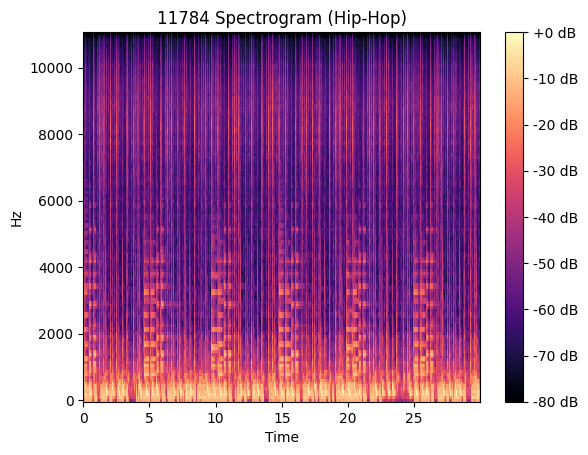

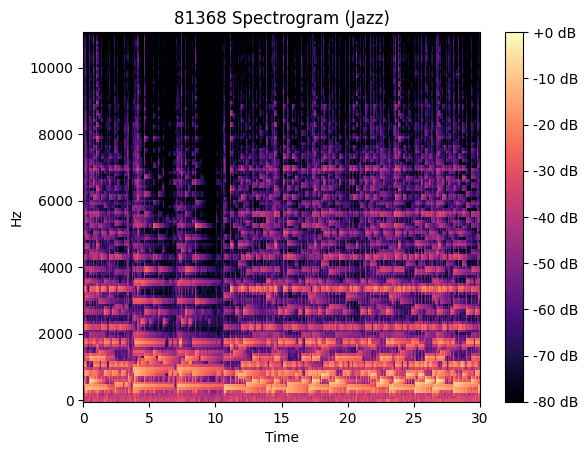

In [61]:
# Plot the spectrograms
for audio_id, info in specs.items():
    fig, ax = plt.subplots()
    img = rosa.display.specshow(info["mel"], x_axis='time', y_axis='linear', ax=ax)
    ax.set(title=f'{audio_id} Spectrogram ({info["genre"]})')
    fig.colorbar(img, ax=ax, format="%+2.f dB")

    file_path = os.path.join(diagrams_path, f"{audio_id}_spec.png")
    fig.savefig(file_path)

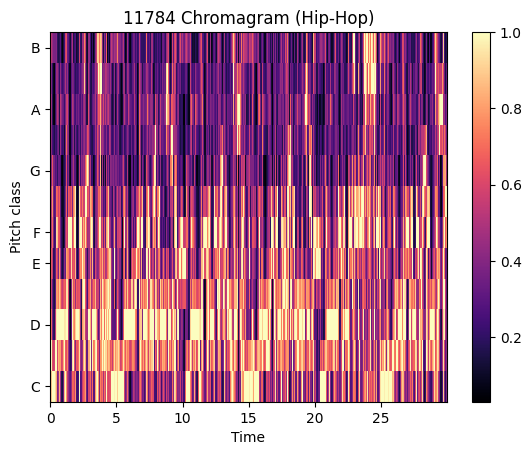

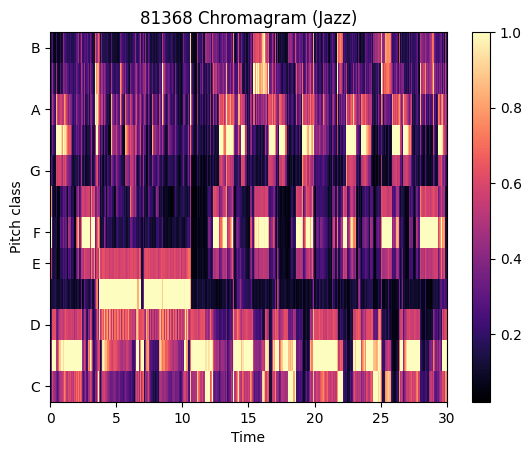

In [62]:
# Plot the chromagrams
for audio_id, info in specs.items():
    fig, ax = plt.subplots()
    img = rosa.display.specshow(info["chroma"], y_axis='chroma', x_axis='time', ax=ax)
    ax.set(title=f'{audio_id} Chromagram ({info["genre"]})')
    fig.colorbar(img, ax=ax)

    file_path = os.path.join(diagrams_path, f"{audio_id}_chroma.png")
    fig.savefig(file_path)

In [80]:
from utils import SpectrogramDataset, CLASS_MAPPING, torch_train_val_split, set_seed

mel_specs = SpectrogramDataset(
    path=mel_specs_path, 
    class_mapping=CLASS_MAPPING, 
    train=True, 
    feat_type='mel', 
    max_length=-1
)
    
train_loader_mel, val_loader_mel = torch_train_val_split(
    dataset=mel_specs, 
    batch_train=BATCH_SIZE,
    batch_eval=BATCH_SIZE, 
    val_size=VAL_SIZE
)
datum = next(iter(train_loader_mel))

data, labels, lengths = datum  

print("Mel-Spectrograms")
print("Data Shape:", data.shape)  
print("Labels:", labels)  
print("Lengths:", lengths) 

batch_size, time_steps, features = data.shape

print(f"Batch Size: {batch_size}")
print(f"Number of time steps: {time_steps}")
print(f"Number of features (frequency bins): {features}")

Mel-Spectrograms
Data Shape: torch.Size([8, 1293, 128])
Labels: tensor([2, 8, 9, 4, 8, 8, 6, 2])
Lengths: tensor([1291, 1293, 1291, 1291, 1293, 1291, 1291, 1291])
Batch Size: 8
Number of time steps: 1293
Number of features (frequency bins): 128


In [78]:
from utils import SpectrogramDataset, CLASS_MAPPING, torch_train_val_split, set_seed

beat_mel_specs = SpectrogramDataset(
    path=beat_mel_specs_path, 
    class_mapping=CLASS_MAPPING, 
    train=True, 
    feat_type='mel', 
    max_length=-1
)
    
train_loader_beat_mel, val_loader_beat_mel = torch_train_val_split(
    dataset=beat_mel_specs, 
    batch_train=BATCH_SIZE,
    batch_eval=BATCH_SIZE, 
    val_size=VAL_SIZE
)
datum = next(iter(train_loader_beat_mel))

data, labels, lengths = datum  

print("Beat-Synced Mel-Spectrograms")
print("Data Shape:", data.shape)  
print("Labels:", labels)  
print("Lengths:", lengths) 

batch_size, time_steps, features = data.shape

print(f"Batch Size: {batch_size}")
print(f"Number of time steps: {time_steps}")
print(f"Number of features (frequency bins): {features}")

Data Shape: torch.Size([8, 129, 128])
Labels: tensor([3, 1, 8, 2, 6, 8, 1, 6])
Lengths: tensor([81, 71, 85, 57, 56, 78, 35, 79])
Batch Size: 8
Number of time steps: 129
Number of features (frequency bins): 128


In [64]:
# load the beat-synced versions of the audio files you visualised above to compare
beat_specs = dict()
for audio_id, info in specs.items():
    audio_path = beat_mel_specs_path+'train/'+audio_id+".fused.full.npy"

    spec = np.load(audio_path)    
    beat_specs[audio_id] = {
        "genre": info["genre"],
        "mel": spec[:128],
        "chroma": spec[128:],
    }

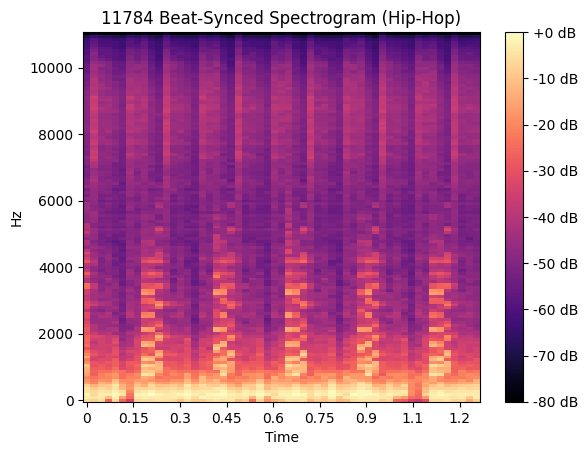

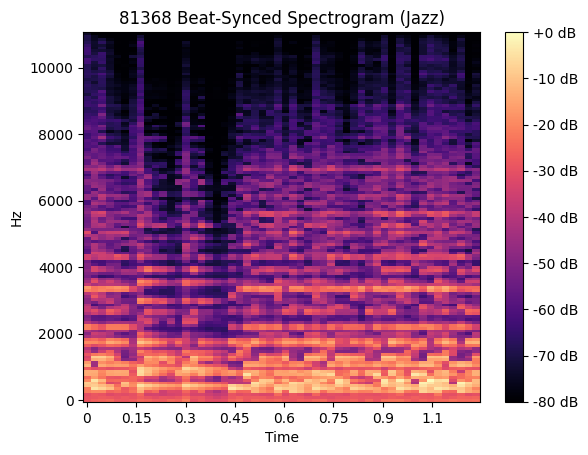

In [65]:
# plot the spectrograms
for audio_id, info in beat_specs.items():
    fig, ax = plt.subplots()
    img = rosa.display.specshow(info["mel"], x_axis='time', y_axis='linear', ax=ax)
    ax.set(title=f'{audio_id} Beat-Synced Spectrogram ({info["genre"]})')
    fig.colorbar(img, ax=ax, format="%+2.f dB")
    
    file_path = os.path.join(diagrams_path, f"{audio_id}_beat_synced_spec.png")
    fig.savefig(file_path)

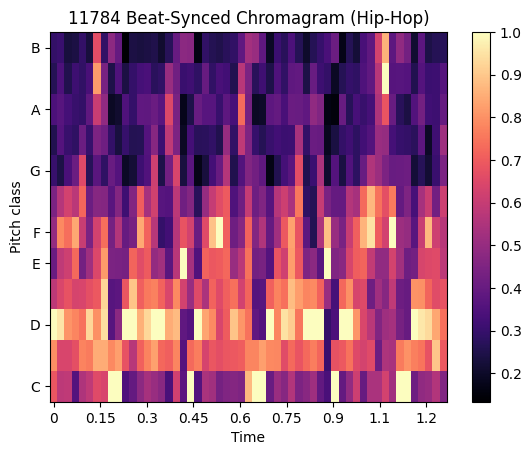

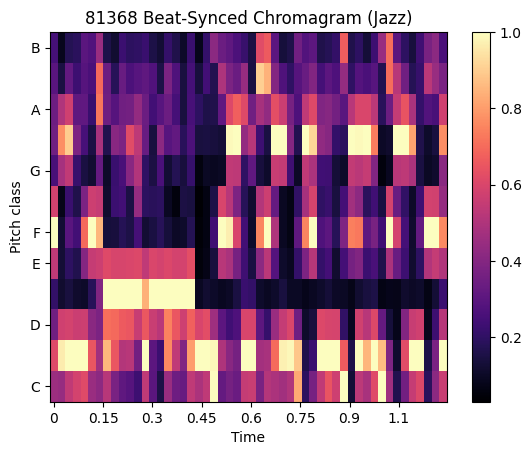

In [66]:
# plot the chromagrams
for audio_id, info in beat_specs.items():
    fig, ax = plt.subplots()
    img = rosa.display.specshow(info["chroma"], y_axis='chroma', x_axis='time', ax=ax)
    ax.set(title=f'{audio_id} Beat-Synced Chromagram ({info["genre"]})')
    fig.colorbar(img, ax=ax)
    
    file_path = os.path.join(diagrams_path, f"{audio_id}_beat_synced_chroma.png")
    fig.savefig(file_path)